source: https://daschw.github.io/recipes/

# Recipes Syntax

In [1]:
struct Result 
    x::Vector{Float64} 
    y::Vector{Float64} 
    ε::Vector{Float64} # maximum error in y
end

Suppose we want to plot the values of `x` and `y` with an error band given by `ε`

In [2]:
using Plots 

In [3]:
res = Result(1:10, cumsum(rand(10)), cumsum(rand(10))/5)

Result([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], [0.4847174684293134, 1.2029620845343696, 1.5291924447571605, 1.670537661109094, 2.6110342989647104, 2.718497986306122, 3.0406371402105954, 3.9866568503102875, 4.6676324909739595, 5.565805959225846], [0.0690907706592148, 0.13652186507851088, 0.24012410391100375, 0.33524415772884625, 0.38459367974948616, 0.45685280914029036, 0.5893393317617723, 0.7285659036581441, 0.7442494293618287, 0.8367983930066707])

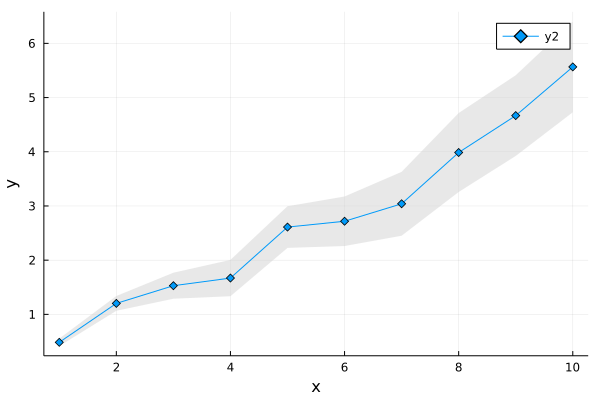

In [6]:
plot(
    res.x, 
    res.y .+ res.ε,
    xlabel="x",
    ylabel="y",
    fill = (res.y .- res.ε, :lightgray, 0.5),
    linecolor = nothing, # just show the fill 
    primary = false, # no legend entry
)

# add the data centerline
plot!(res.x, res.y, marker=:diamond)

instead of typing this many times, we can define a **user recipe** to tell Plots what to do with an input of the type `Result`. 

In [7]:
@recipe function f(r::Result; ε_max = 0.5)
    # set default attribute values with --> 
    xlabel --> "x" 
    ylabel --> "y" 
    markershape --> :diamond 
    
    # add a series for error band 
    @series begin
        # force an argument with ':='
        seriestype := :path 
        # ignore sries in legend and color cycling 
        primary := false 
        linecolor := nothing 
        fillcolor := :lightgray 
        fillalpha := 0.5 
        fillrange := r.y .- r.ε
        
        # don't show markers for error band 
        markershape := :none 
        
        # return the series data 
        r.x, r.y .+ r.ε
    end
    
    # get seriescolor passed by user 
    c = get(plotattributes, :seriescolor, :auto)
    # highlight big errors, else, use c 
    markercolor := ifelse.(r.ε .> ε_max, :red, c)
    
    
    # return data so that plot will do plot(r.x, r.y) 
    r.x, r.y
end

We can set plot attributes using `attr --> val` which the user can override when they call `plot()`. We can force certain attributes via `attr := val`. 

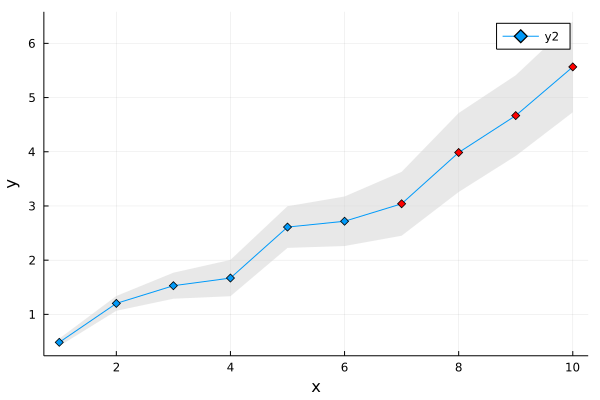

In [8]:
plot(res)

since the recipe just passes the returned values to whatever `Plots` command was used, we can even do the following:

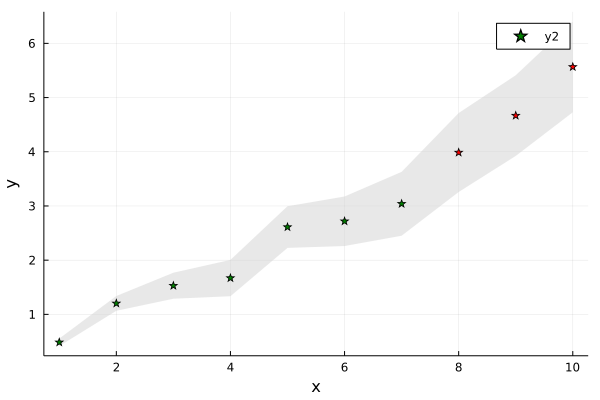

In [9]:
scatter(res, ε_max = 0.7, color=:green, marker=:star)

# Recipe types 

There are four recipe types determined by the signature

## User Recipes 
called early in the processing pipeline and used to design custom visualizations, i.e. 
`@recipe function f(custom_arg_1::T, custom_arg_2::S, ...; ...)`

## Type Recipes 
define one-to-one mappings from custom types to something `Plots` already supports. 

`@recipe function f(::Type{T}, val::T) where T`

## Plot Recipes 
called after all input data is processed by type recipes but before plots and subplots are set-up. This allows for custom layouts and plot-wide attributes. 

`@recipe function f(::Type{Val{:myplotrecipename}}, plt::AbstractPlot; ...)` 

## Series Recipes 

series recipes are applied recursively unitl the current backend has a series type it supports. Ex: convert data of bar plot to coordinates of the shapes that define the bars. 

`@recipe function f(::Type{Val{:myseriesrecipename}}, x, y, z; ...)`

# Example: User Recipes 

User recipes (like above) can also be used to define custom visualizations without necessarily needing a custom type. We just dispatch on a type via `@userplot` macro. 

In [10]:
@userplot MyPlot

myplot! (generic function with 2 methods)

In [11]:
methods(MyPlot)

# 1 method for type constructor:
[1] MyPlot(args) in Main at /Users/jwaczak/.julia/packages/RecipesBase/qpxEX/src/RecipesBase.jl:372

The above expands to: 
```Julia 
mutable struct MyPlot
    args
end
export myplot, myplot!
myplot(args...; kw...) = plot(MyPlot(args); kw...)
myplot!(args...; kw...) = plot!(MyPlot(args); kw...)
```

In [12]:
@userplot UserPie
@recipe function f(up::UserPie) 
    y = up.args[end] # extract y from the args 
    
    # if we are passed 2 args, use the first as labels 
    labels = length(up.args) == 2 ? up.args[1] : eachindex(y)
    
    framestyle --> :none 
    aspect_ratio --> true 
    
    s = sum(y) 
    θ = 0
    
    # add a shape for each slie of pie 
    for i ∈ 1:length(y) 
        θ_new = θ + 2π * y[i] / s 
        coords = [(0.0, 0.0); Plots.partialcircle(θ, θ_new, 50)]
        
        @series begin 
            seriestype := :shape 
            label --> string(labels[i])
            coords 
        end
        θ = θ_new
        
    end
    
    primary := false 
    ()
end

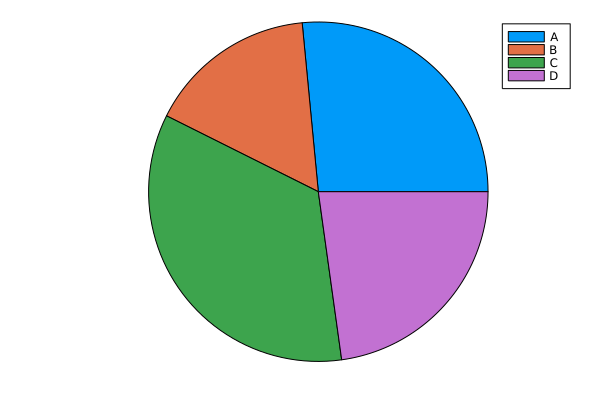

In [15]:
userpie('A':'D', rand(4))

# Example: Type Recipes 

suppose we create a custom wrapper around another type and plot the wrapped object. 

In [16]:
struct MyWrapper
    v::Vector
end

In [17]:
# when plots sees MyWrapper, it will just use the vector part
@recipe f(::Type{MyWrapper}, mw::MyWrapper) = mw.v

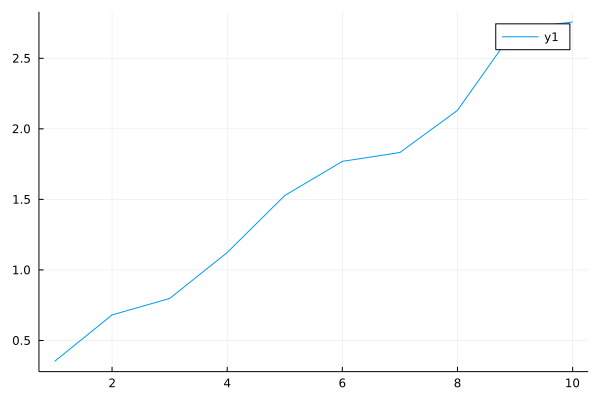

In [18]:
mw = MyWrapper(cumsum(rand(10)))
plot(mw)

For element-wise conversion of custom types we can do the following

In [20]:
struct MyTime
    h::Int
    m::Int
end

# show MyTime(1, 30) as 01:30 
time_string(mt) = join((lpad(string(c), 2, "0") for c in (mt.h, mt.m)), ":")
minutes_since_midnight(mt) = 60 * mt.h + mt.m
formatter(n) = time_string(MyTime(divrem(n, 60)...))

# define the recipe 
@recipe f(::Type{MyTime}, mt::MyTime) = (minutes_since_midnight, formatter)

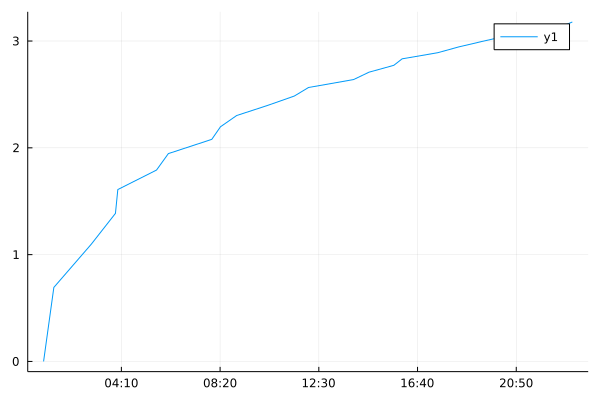

In [23]:
times = MyTime.(0:23, rand(0:59, 24))
vals = log.(1:24) 

plot(times, vals)

# Example: Plot Recipes 

let's define a plotrecipe that shows data with linear y scale in one plot and a lograrithmic yscale in another

In [25]:
@recipe function f(::Type{Val{:yscaleplot}}, plot::AbstractPlot)
    x,y = plotattributes[:x], plotattributes[:y]
    layout := (1,2) # 1 row, 2 cols 
    
    for (i, scale) ∈ enumerate((:linear, :log))
        @series begin
            title --> string(scale, " scale")
            seriestype := :path
            subplot := i 
            yscale := scale
        end
    end 
end

now we call `plot(...;..., seriestype = :yscaleplot)`

In [26]:
@shorthands myseries 

myseries! (generic function with 1 method)

expands to 
```Julia 
export myseries, myseries!
myseries(args...; kw...) = plot(args...; kw..., seriestype = :myseries)
myseries!(args...; kw...) = plot!(args...; kw..., seriestype = :myseries)
```

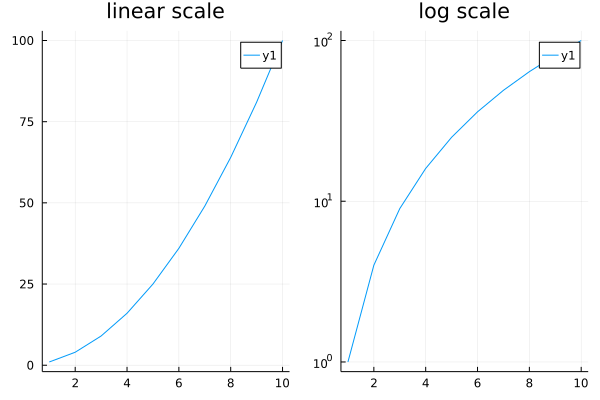

In [27]:
@shorthands yscaleplot 

yscaleplot((1:10).^2)